In [3]:
import copernicusmarine
import xarray as xr

def retrieve_data(lats, longs, parameter):
    """
    Retrieve data from the Copernicus Marine server.

    Parameters
    ----------
    lats : tuple
        (min_lat, max_lat) for the region of interest.
    longs : tuple
        (min_lon, max_lon) for the region of interest.
    parameter : str
        Parameter to retrieve. Options:
        - "chl" : Chlorophyll
        - "sst" : Temperature ("thetao_mean")
        - "sal" : Salinity ("so_mean")
        - "ssh" : Sea Height ("zos_mean")
        - "mlt" : Mixed Layer Thickness ("mlotst_mean")
        - "eke" : Eddy Kinetic Energy ("uo_mean , vo_mean")
    start_date : str, optional
        Start date in ISO format (YYYY-MM-DD). If None, take earliest.
    end_date : str, optional
        End date in ISO format (YYYY-MM-DD). If None, take latest.

    Returns
    -------
    xarray.Dataset
        Dataset containing the requested variable for the specified region and time.
    """
    # If we want a pretty green chlorophyll plot we need to open a different dataset.
    if parameter == "chl":
        dataset_id = "cmems_mod_glo_bgc-pft_anfc_0.25deg_P1D-m"
        variables = ["chl"]
    else:
        dataset_id = "cmems_mod_glo_phy-mnstd_my_0.25deg_P1D-m"
        parameter_map = {
            "sst": "thetao_mean",
            "sal": "so_mean",
            "ssh": "zos_mean",
            "mlt": "mlotst_mean",
            "eke": ["uo_mean", "vo_mean"]}
    if parameter not in parameter_map:
        raise ValueError(f"Invalid parameter '{parameter}'. Choose from {list(parameter_map.keys())}")
    variable = parameter_map[parameter]

    ds = copernicusmarine.open_dataset( dataset_id=dataset_id, variables=variable, minimum_latitude=lats[0], 
                                        maximum_latitude=lats[1], minimum_longitude=longs[0], maximum_longitude=longs[1])

    # Compute Eddy Kinetic Energy if 'eke' is selected
    if parameter == "eke":
        u = ds["uo_mean"]
        v = ds["vo_mean"]
        eke = 0.5 * (u**2 + v**2)
        ds = eke.to_dataset(name="eke")

    print(ds)
    return ds    

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from matplotlib.animation import FuncAnimation, PillowWriter
import xarray as xr
import numpy as np

def update_base_map(longs, lats, parameter_name):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([longs[0], longs[1], lats[0], lats[1]], crs=ccrs.PlateCarree())

    # Put a background image on for nice sea rendering.
    ax.stock_img()

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth.
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    SOURCE = 'OceanHackWeek2025'
    LICENSE = 'public domain'

    # Add our states feature.
    ax.add_feature(states_provinces, edgecolor='gray')
    # Add land feature, overriding the default negative zorder so it shows
    # above the background image.
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')

    # Add a text annotation for the license information to the
    # the bottom right corner.
    text = AnchoredText('\u00A9 {}; license: {}'
                        ''.format(SOURCE, LICENSE),
                        loc=4, prop={'size': 6}, frameon=True)
    ax.add_artist(text)

    plt.show()

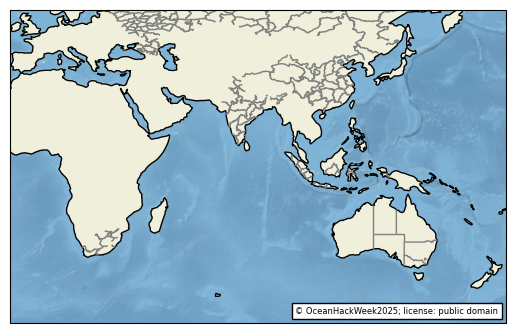

In [5]:
update_base_map([-10, 180], [-60, 60], "beans")